In [1]:
#Library Load ins
import numpy as np
import os
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from keras.models import Model
import tensorflow as tf

#Import Keras optimizers
#from scipy.optimize import fmin_l_bfgs_b
print('Libraries imported successfully :D')

Using TensorFlow backend.


Libraries imported successfully :D


<h3> Assure we have files for Style Transfer </h3>

In [2]:
print(os.listdir('greatest_artwork/'))

['resized', '.DS_Store', 'images', 'artists.csv']


<h3> Create two paths (one for style and one for photo NN is transferring style to </h3>

In [3]:
Style_ = 'greatest_artwork/images/images/'

#Trans_Photo = 'TBD'

In [49]:
style_image_path = Style_ + 'Leonardo_da_Vinci/Leonardo_da_Vinci_121.jpg'

t_photo_path = 'Githubphoto.jpg'

In [50]:
#Dimensions of the transfer picture
w, h = load_img(t_photo_path).size
img_rows = 400
img_cols = int(w * img_rows / h)

<h3> Preprocessing Function </h3>

In [51]:
def preprocess_img(image_path):
    img = load_img(image_path, target_size = (img_rows, img_cols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

<h3> Decompression Function </h3>

In [52]:
def decompress_img(x):
    #Convert a tensor into a valid image
    x = x.reshape((img_rows, img_cols, 3))
    
    #remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    #Convert to  RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

<h3> Transfer Photo </h3>

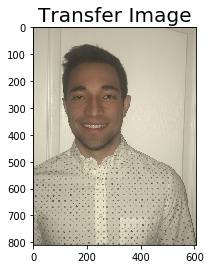

In [53]:
plt.figure()
plt.title('Transfer Image', fontsize = 20)
img_ = load_img(t_photo_path)
plt.imshow(img_)

<h3> Style Photo </h3>

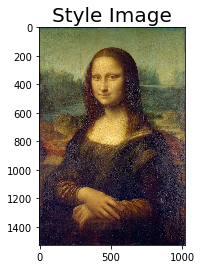

In [54]:
plt.figure()
plt.title('Style Image', fontsize = 20)
img_ = load_img(style_image_path)
plt.imshow(img_)

<h3> Build with VGG19 model, would like to try ImageNet in near future </h3>

In [10]:
#The model has already been imported (can play around with hyper-tuning later)
from keras.applications import VGG19
model = vgg19.VGG19(weights = 'imagenet', include_top = False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
#print(outputs_dict['block5_conv2'])

#Create model to return activation values for every layer
feature_extract = keras.Model(inputs = model.inputs, outputs = outputs_dict)

print('Model successfully loaded')

Model successfully loaded


VGG19 is normally used for Classification and since this is not a classification problem. I will ONLY include the layers used needed for style transfer.

In [19]:
content_ = 'block5_conv2'

#Stylistic Layers
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_)
num_stylistic_layers = len(style_layers)

<h3> Calculate Content Loss and Style Loss </h3>

Content loss defined as the MSE between the feature map of the content image and the feature map for the generated (target) image

In [20]:
#Loss function that aims to maintain the 'content' of the base image
def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))

Style loss is defined as the MSE for the Gram-matrices, which are essentially matrices of dot-products for the vectors of feature activations based on the style layer (s)

In [27]:
#Create gram matrix of an image tensor
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [28]:
#Style Loss 
def style_loss(style, comb):
    S = gram_matrix(style)
    C = gram_matrix(comb)
    channels = 3
    size = img_rows * img_cols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [29]:
#Variation Loss
def var_loss(x):
    a = tf.square(x[:, : img_rows - 1, : img_cols - 1, :] - x[:, 1:, : img_cols - 1, :])
    b = tf.square(x[:, : img_rows - 1, : img_cols - 1, :] - x[:, : img_rows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [35]:
#Compute loss
content_weight = 2.5e-8
style_weight = 1e-6
var_weight = 1e-6

def compute_loss(comb_img, base_img, style_ref_img):
    input_tensor = tf.concat([base_img, style_ref_img, comb_img], axis = 0)
    
    features = feature_extract(input_tensor)
    
    #Initialize loss
    loss = tf.zeros(shape = ())
    
    #Add content loss
    layer_features = features[content_]
    base_img_feats = layer_features[0, :, :, :]
    comb_feats = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_img_feats, comb_feats)
    
    #Style Loss
    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_ref_feats = layer_features[1, :, :, :]
        comb_feats = layer_features[2, :, :, :]
        sl = style_loss(style_ref_feats, comb_feats)
        loss += (style_weight / len(style_layers)) * sl
        
    #Add variation loss
    loss += var_weight * var_loss(comb_img)
    
    return loss
        
    

In [36]:
@tf.function
def compute_loss_grads(comb_img, base_img, style_ref_img):
    with tf.GradientTape() as tape:
        loss = compute_loss(comb_img, base_img, style_ref_img)
    grads = tape.gradient(loss, comb_img)
    return loss, grads

In [ ]:
#Optimizer and run the style transfer
optim = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 100.0, decay_steps = 100, decay_rate = 0.90))

base_img = preprocess_img(t_photo_path)
style_ref_img = preprocess_img(style_image_path)

comb_img = tf.Variable(preprocess_img(t_photo_path))

iterations = 400
for  i in range(1, iterations + 1):
    loss, grads = compute_loss_grads(comb_img, base_img, style_ref_img)
    optim.apply_gradients([(grads, comb_img)])
    
    if i % 50 == 0:
        print('iteration %d: loss = %.3f' % (i, loss))
        img = decompress_img(comb_img.numpy())
        fname = 'image_combination_artistic.png'
        keras.preprocessing.image.save_img(fname, img)

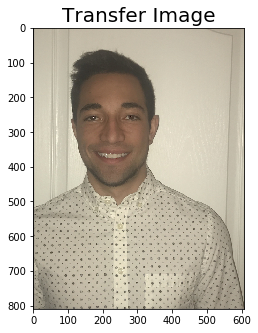

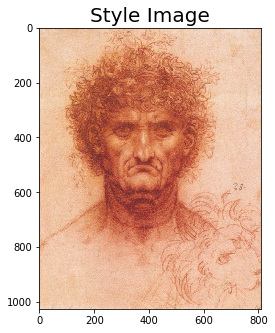

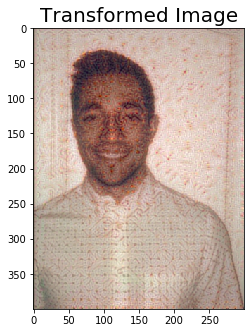

In [48]:
#Visualize it Albewt

plt.figure(figsize = (30,30))
plt.subplot(5,5,1)
plt.title('Transfer Image', fontsize = 20)
img_b = load_img(t_photo_path)
plt.imshow(img_b)

plt.figure(figsize = (30,30))
plt.subplot(5,5,2)
plt.title('Style Image', fontsize = 20)
img_s = load_img(style_image_path)
plt.imshow(img_s)

plt.figure(figsize = (30,30))
plt.subplot(5,5,3)
plt.title('Transformed Image', fontsize = 20)
img_sf = load_img('image_combination_artistic.png')
plt.imshow(img_sf)

<h3> Great job Da Vinci, he painted me very well xD </h3>

I am looking forward to improving  this relatively simple model in the future and testing on different images. Feel free to try out some yourself :)